In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

# Text Preprocessing & Baseline Model
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.multioutput import MultiOutputRegressor

# Evaluation
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr

# Transformer Model (PyTorch)
import torch
from torch.utils.data import Dataset
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import Trainer
from transformers import TrainingArguments
from datasets import load_dataset, Dataset as HfDataset


import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Read in data
file_path = "/train_subtask1.csv"
df = pd.read_csv(file_path)
df.info()
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2764 entries, 0 to 2763
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   user_id           2764 non-null   int64  
 1   text_id           2764 non-null   int64  
 2   text              2764 non-null   object 
 3   timestamp         2764 non-null   object 
 4   collection_phase  2764 non-null   int64  
 5   is_words          2764 non-null   bool   
 6   valence           2764 non-null   float64
 7   arousal           2764 non-null   float64
dtypes: bool(1), float64(2), int64(3), object(2)
memory usage: 154.0+ KB
   user_id  text_id                                               text  \
0        3      251  I ' ve been feeling just fine . Nice and relax...   
1        3      252  I ' ve been feeling pretty good . This is my l...   
2        3      253  Still feeling sick today and sneezing alot wit...   
3        3      254  I ' m still feeling kinda sickly b

In [ ]:
# EDA - Check for Missing Values ---

# Check for nulls, especially in the 'text' column
print(f"Null values in 'text' column: {df['text'].isnull().sum()}")

# For simplicity, we'll drop any rows where the text is missing, as we can't train on them.
df.dropna(subset=['text'], inplace=True)
print(f"Shape after dropping null texts: {df.shape}")

Null values in 'text' column: 0
Shape after dropping null texts: (2764, 8)


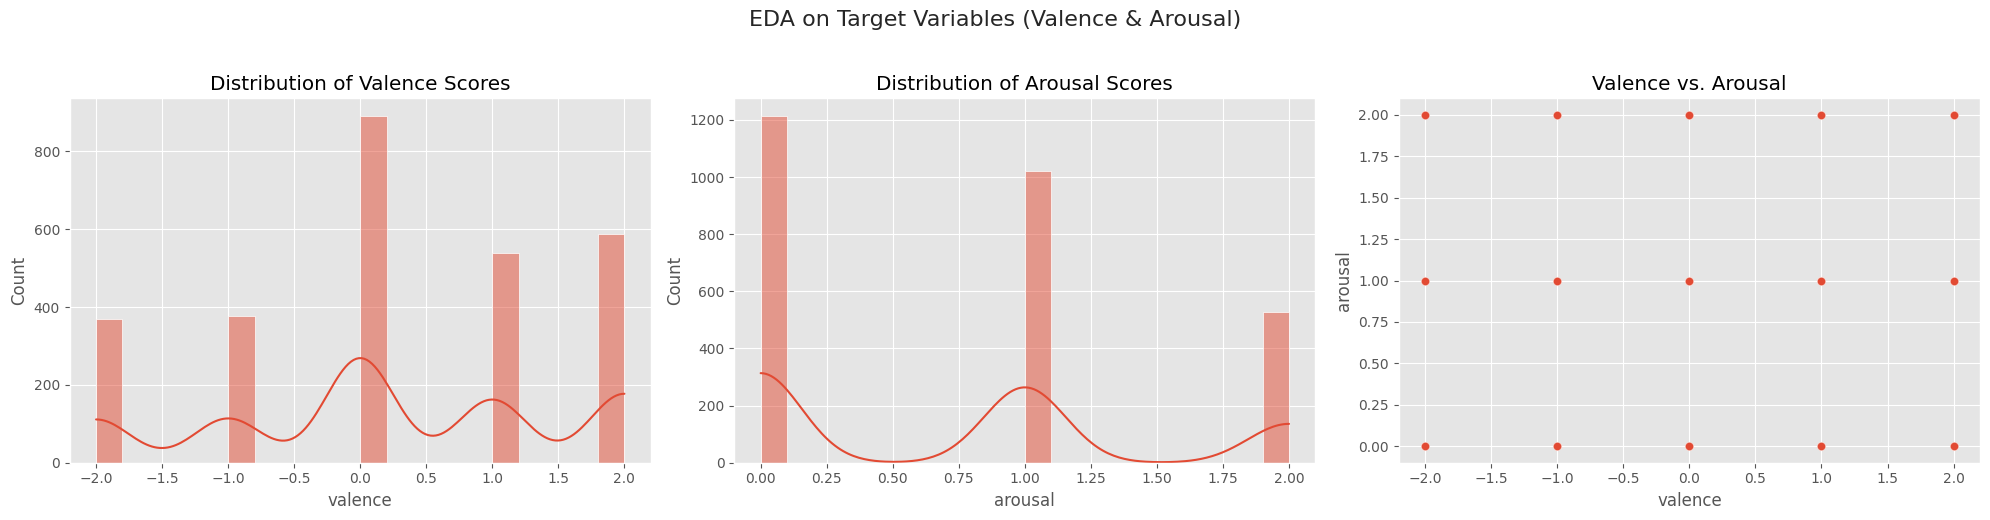

In [ ]:
# EDA - Analyze Target Variables (Valence & Arousal)

# Set up the plotting area
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
sns.set_style("whitegrid")

# Plot 1: Valence Distribution
sns.histplot(df['valence'], kde=True, ax=axes[0], bins=20)
axes[0].set_title('Distribution of Valence Scores')

# Plot 2: Arousal Distribution
sns.histplot(df['arousal'], kde=True, ax=axes[1], bins=20)
axes[1].set_title('Distribution of Arousal Scores')

# Plot 3: Valence vs. Arousal
# This helps us understand the relationship between our two target variables.
sns.scatterplot(data=df, x='valence', y='arousal', ax=axes[2], alpha=0.3)
axes[2].set_title('Valence vs. Arousal')
plt.suptitle('EDA on Target Variables (Valence & Arousal)', fontsize=16, y=1.03)
plt.tight_layout()
plt.show()

In [ ]:
# Create Train/Validation Split by User

# Get a unique list of all user IDs
all_user_ids = df['user_id'].unique()
print(f"Total unique users: {len(all_user_ids)}")

# Split the list of user IDs
train_user_ids, val_user_ids = train_test_split(all_user_ids, test_size=0.2, random_state=42)

print(f"Training users: {len(train_user_ids)}")
print(f"Validation users: {len(val_user_ids)}")

# Create the final DataFrames
train_df = df[df['user_id'].isin(train_user_ids)].copy()
val_df = df[df['user_id'].isin(val_user_ids)].copy()

print(f"\nTraining data shape: {train_df.shape}")
print(f"Validation data shape: {val_df.shape}")

Total unique users: 137
Training users: 109
Validation users: 28

Training data shape: (2357, 8)
Validation data shape: (407, 8)


In [ ]:
# Define Model and Tokenizer
# We'll use 'distilbert-base-uncased'. It's a smaller, faster version of BERT.
MODEL_NAME = "roberta-base"

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
token_lengths = [len(tokenizer(text)["input_ids"]) for text in df["text"]]
max_token_length = max(token_lengths)
print(max_token_length)

277


In [ ]:
# Prepare Data for Hugging Face `datasets`
# The Trainer API works best with its own `Dataset` format.

# We need to rename our label columns to 'labels' for the Trainer
# And the model expects a *single* 'labels' tensor [valence, arousal]
def format_data_for_hf(df):
    df_hf = df[['text', 'valence', 'arousal']].copy()
    # Create the 'labels' column as a list
    df_hf['labels'] = df_hf.apply(lambda row: [row['valence'], row['arousal']], axis=1)
    df_hf = df_hf.drop(columns=['valence', 'arousal'])
    return df_hf

train_hf_df = format_data_for_hf(train_df)
val_hf_df = format_data_for_hf(val_df)

# Convert pandas DataFrames to Hugging Face Dataset objects
train_dataset = HfDataset.from_pandas(train_hf_df)
val_dataset = HfDataset.from_pandas(val_hf_df)

print(train_dataset)
print(val_dataset[0])

Dataset({
    features: ['text', 'labels', '__index_level_0__'],
    num_rows: 2357
})
{'text': 'Content , Calm , Happy , Indifferent , Fine', 'labels': [2.0, 0.0], '__index_level_0__': 116}


In [ ]:
# Tokenize the Datasets ---
# We create a function to tokenize the 'text' field

def tokenize_function(examples):
    # max_length=128 is a good default for essays of this length.
    # We truncate longer texts and pad shorter ones.
    return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=256)

# Apply the tokenization to both datasets
# batched=True makes this much faster
tokenized_train_dataset = train_dataset.map(tokenize_function, batched=True)
tokenized_val_dataset = val_dataset.map(tokenize_function, batched=True)

# Set the format to PyTorch tensors
tokenized_train_dataset = tokenized_train_dataset.with_format("torch")
tokenized_val_dataset = tokenized_val_dataset.with_format("torch")

# Remove the original 'text' column as it's no longer needed
tokenized_train_dataset = tokenized_train_dataset.remove_columns(['text'])
tokenized_val_dataset = tokenized_val_dataset.remove_columns(['text'])

print("\n--- Tokenized Dataset Example ---")
print(tokenized_train_dataset[0])

Map:   0%|          | 0/2357 [00:00<?, ? examples/s]

Map:   0%|          | 0/407 [00:00<?, ? examples/s]


--- Tokenized Dataset Example ---
{'labels': tensor([1., 1.]), '__index_level_0__': tensor(0), 'input_ids': tensor([    0,   100,   128,  5030,    57,  2157,    95,  2051,   479, 16911,
            8, 11956, 29942,  5902,    15,   127,   360,   160,    31,   173,
         1408,    86,    19,   127,  7172,    23,   184,   479,    38,   128,
          475,    45,   686,    99,  1493,     7,   224,   479,    38,   128,
          475,    11,    10,   205,  6711,  1437, 46082, 47793, 38917,     2,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     

In [ ]:
# Load the Model

# We load 'AutoModelForSequenceClassification'
# We tell it we have 2 labels (valence, arousal)
# We MUST tell it this is a REGRESSION problem, not classification.
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2,  # 2 outputs: valence, arousal
    problem_type="regression" # This is CRITICAL. It ensures we use MSELoss.
)

# If you have a GPU, move the model to the GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"Model loaded on {device}")

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded on cpu


In [ ]:
# Define Compute Metrics Function
# The Trainer needs a function to calculate our Pearson Correlation metric
# at the end of each epoch.

def compute_metrics(eval_pred):
    # eval_pred is a tuple of (logits, labels)
    logits, labels = eval_pred

    # Separate predictions and labels for valence and arousal
    preds_v = logits[:, 0]
    labels_v = labels[:, 0]

    preds_a = logits[:, 1]
    labels_a = labels[:, 1]

    # Calculate Pearson Correlation for each
    v_corr, _ = pearsonr(labels_v, preds_v)
    a_corr, _ = pearsonr(labels_a, preds_a)

    # Calculate the mean correlation (our main metric)
    mean_corr = (v_corr + a_corr) / 2

    # Also return MSE (what the model is optimizing)
    mse = mean_squared_error(labels, logits)

    return {
        'pearson_r_valence': v_corr,
        'pearson_r_arousal': a_corr,
        'pearson_r_mean': mean_corr,
        'mse': mse
    }

In [ ]:
# Define Training Arguments

training_args = TrainingArguments(
    output_dir="./results_roberta_stable",
    num_train_epochs=5,
    per_device_train_batch_size=8,       # Keep this small to fit in memory
    gradient_accumulation_steps=4,       # <--- INCREASED: Now effective batch size is 8 * 4 = 32!
    per_device_eval_batch_size=32,
    learning_rate=1e-5,                  # Keep this low
    warmup_ratio=0.1,                    # Keep warmup
    weight_decay=0.01,
    logging_steps=50,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="pearson_r_mean",
    greater_is_better=True,
    report_to="none"
)

In [ ]:
# Initialize the Trainer

trainer = Trainer(
    model=model,                         # The model to train
    args=training_args,                  # Training arguments
    train_dataset=tokenized_train_dataset, # Training dataset
    eval_dataset=tokenized_val_dataset,    # Validation dataset
    compute_metrics=compute_metrics      # The function to compute metrics
)

In [ ]:
# Train the Model
# This will take some time, especially if you are not on a GPU.
print("Starting Transformer model training...")
trainer.train()
print("Training complete.")

Starting Transformer model training...


Epoch,Training Loss,Validation Loss,Pearson R Valence,Pearson R Arousal,Pearson R Mean,Mse
1,1.238500,0.857236,0.597122,0.306108,0.451615,0.857236
2,0.718100,0.835155,0.634301,0.384887,0.509594,0.835155
3,0.548700,0.828824,0.657019,0.360080,0.508549,0.828824
4,0.523500,0.817372,0.653901,0.405862,0.529881,0.817373
5,0.462600,0.808451,0.657031,0.404914,0.530972,0.808451


Training complete.


In [ ]:
# Evaluate the Best Model
print("Evaluating best model on validation set...")
eval_results = trainer.evaluate()

print("\n--- Final Model Evaluation ---")
print(f"Valence Pearson Correlation: {eval_results['eval_pearson_r_valence']:.4f}")
print(f"Arousal Pearson Correlation: {eval_results['eval_pearson_r_arousal']:.4f}")
print(f"**Mean Pearson Correlation:** {eval_results['eval_pearson_r_mean']:.4f}")
print(f"Mean Squared Error (MSE): {eval_results['eval_mse']:.4f}")

Evaluating best model on validation set...



--- Final Model Evaluation ---
Valence Pearson Correlation: 0.6570
Arousal Pearson Correlation: 0.4049
**Mean Pearson Correlation:** 0.5310
Mean Squared Error (MSE): 0.8085


In [ ]:
test_df = val_df.copy()
print(f"Test data loaded. Shape: {test_df.shape}")

# Prepare the test data in the same way
test_hf_df = test_df[['text_id', 'text']].copy()
test_dataset_hf = HfDataset.from_pandas(test_hf_df)

# Tokenize the test data
tokenized_test_dataset = test_dataset_hf.map(tokenize_function, batched=True)
tokenized_test_dataset = tokenized_test_dataset.with_format("torch")
tokenized_test_dataset = tokenized_test_dataset.remove_columns(['text'])

print(tokenized_test_dataset)

Test data loaded. Shape: (407, 8)


Map:   0%|          | 0/407 [00:00<?, ? examples/s]

Dataset({
    features: ['text_id', '__index_level_0__', 'input_ids', 'attention_mask'],
    num_rows: 407
})


In [ ]:
# Generate Predictions

print("Generating predictions on test set...")

# The .predict() method returns an object with predictions, labels (if any), and metrics
test_predictions = trainer.predict(tokenized_test_dataset)

# The raw predictions (logits) are in the .predictions attribute
pred_logits = test_predictions.predictions

print(f"Predictions shape: {pred_logits.shape}") # Should be (num_test_samples, 2)

Generating predictions on test set...


Predictions shape: (407, 2)


In [ ]:
# Format and Save Submission File

# The required format is: text_id, pred_valence, pred_arousal

# Extract predicted valence and arousal
pred_valence = pred_logits[:, 0]
pred_arousal = pred_logits[:, 1]

# Create the submission DataFrame
submission_df = pd.DataFrame({
    'text_id': test_df['text_id'],
    'pred_valence': pred_valence,
    'pred_arousal': pred_arousal
})

# Define the submission file name
submission_filename = "pred_subtask1.csv"

# Save to CSV, index=False is required by the competition
submission_df.to_csv(submission_filename, index=False)

print(f"\nSuccessfully created submission file: {submission_filename}")
print(submission_df.head())


Successfully created submission file: pred_subtask1.csv
     text_id  pred_valence  pred_arousal
116     1292      1.245957      0.496828
117     1293      0.790964      0.430339
118     1294     -0.507892      1.045534
119     1295      1.905839      0.579001
120     1296      1.585762      0.446821
